# Xarray sparse matrix example

This is an example of add a sparse matrix variable to an Xarray. This can be done via the `sparse` module. Not this module is a wrapper of `scipy.sparse`. Inspired by the [unit test of Xarray](https://github.com/pydata/xarray/blob/main/xarray/tests/test_sparse.py)

Although `xarray` support support a data variable

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%load_ext memory_profiler

## Prepare the test data

In [2]:
# Set data cube dimension
n_azimuth=2000
n_range=1000
n_time=4

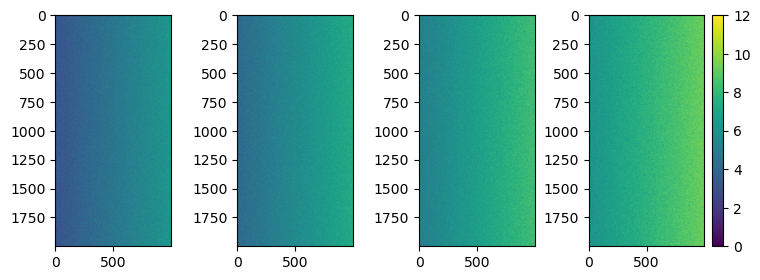

In [3]:
# signal
signal = np.zeros((n_time,n_azimuth,n_range))
signal[0,:,:] = np.tile(np.linspace(0,np.pi,num=n_range), (n_azimuth,1))
for i in range(1,n_time):
    signal[i,:,:] = signal[0,:,:]+i

# noise
np.random.seed(0)
noise = np.random.rand(n_time,n_azimuth,n_range)*2*np.pi

# obs
obs = signal + noise

# visualize
fig, ax = plt.subplots(1,n_time)
fig.set_size_inches(9,3)
for i in range(n_time):
    im = ax[i].imshow(obs[i], vmin=0, vmax=12)
plt.colorbar(im)

In [4]:
ds = xr.Dataset(
    data_vars=dict(
        obs=(["time", "azimuth", "range"], obs),
    ),
    coords=dict(
        azimuth=np.arange(n_azimuth),
        range=np.arange(n_range),
        time=np.arange(n_time),
    ),
)

ds_pointset = ds.stack(points=('azimuth', 'range'))

In [5]:
# Make a subsetted pointset
mask = ds.obs.std(axis=0)<0.5
ds_masked = ds.where(mask)
pointset = ds_masked.stack(points=('azimuth', 'range'))
pointset = pointset.dropna('points', subset=['obs'])
pointset['obs1'] = pointset.obs+100

## Update the original DataSet with a sparse array

Original DataSet: `ds_pointset`.

Processed DataSet: `pointset`.

There is a new variable `obs1` in `pointset`. We would like to save this variable as a sparse matrix first. Then add this sparse matrix as a new variable to `ds_pointset`.

In [6]:
import sparse

da_dense = xr.DataArray(coords=ds_pointset.coords)
da_dense.loc[dict(points = pointset.obs1.points)] = pointset.obs1.data


dense = da_dense.data
dense[np.where(np.isnan(dense))] = 0
spm = sparse.COO.from_numpy(da_dense.data, fill_value=dense[0,0])

da_sparse= xr.DataArray(data=sparse.COO(da_dense.data), coords=ds_pointset.coords) 

da_sparse

Format,coo
Data Type,float64
Shape,"(4, 2000000)"
nnz,139540
Density,0.0174425
Read-only,True
Size,3.2M
Storage ratio,0.1


In [7]:
%memit
ds = ds.assign(obs1=da_sparse)
ds

peak memory: 754.65 MiB, increment: -6.39 MiB


Format,coo
Data Type,float64
Shape,"(4, 2000000)"
nnz,139540
Density,0.0174425
Read-only,True
Size,3.2M
Storage ratio,0.1


In [8]:
%memit
# The storage in Zarr has not been supported yet
ds.to_zarr("database.zarr", mode='a')

peak memory: 754.84 MiB, increment: 0.18 MiB


TypeError: SparseArray.astype() got an unexpected keyword argument 'order'